Импорт библиотек:

In [1]:
import os
import nltk
import statistics
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Напишем функцию `csv_maker` для сбора файлов формата `.txt` в единый файл формата `.csv`:

In [20]:
def csv_maker(path_name, path):
    data = []
    folder = os.listdir(path)
    for names in folder:
        sentiment = 0 if path.split('\\')[2] == 'neg' else 1 
        try:
            with open(path +'\\'+ names, 'r') as file:
                text = file.read().replace('\n', '').replace('''<br /><br />''', '')
                data.append([text, sentiment])
        except: pass
    df = pd.DataFrame(columns = ['Review text', 'Mood'], data = data)
    df.to_csv(path_name + '.csv', index = False)

Скачиваем данные, переводим их в формат `.csv` с помощью указанной выше функции:

In [ ]:
%%bash
wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf allImdb.tar.gz

In [21]:
csv_maker('csv_data\\train_pos', 'aclImdb\\train\\pos')
csv_maker('csv_data\\train_neg', 'aclImdb\\train\\neg')
csv_maker('csv_data\\test_pos', 'aclImdb\\test\\pos')
csv_maker('csv_data\\test_neg', 'aclImdb\\test\\neg')

Считываем файлы формата `.csv`, формируем из них большой датасет, с которым будет идти работа далее:

In [2]:
train_pos = pd.read_csv('csv_data\\train_pos.csv')
train_neg = pd.read_csv('csv_data\\train_neg.csv')
frames_train = [train_pos, train_neg]
train_data_binary = pd.concat(frames_train, ignore_index = True)

test_pos = pd.read_csv('csv_data\\test_pos.csv')
test_neg = pd.read_csv('csv_data\\test_neg.csv')
frames_test = [test_pos, test_neg]
test_data_binary = pd.concat(frames_test, ignore_index = True)

frames = [train_data_binary, test_data_binary]
binary_data = pd.concat(frames, ignore_index = True)
binary_data.to_csv('binary_data.csv')

In [35]:
binary_data

,Review text,Mood
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
49982,I occasionally let my kids watch this garbage ...,0
49983,When all we have anymore is pretty much realit...,0
49984,The basic genre is a thriller intercut with an...,0
49985,Four things intrigued me as to this film - fir...,0


Проверяем, есть ли дубликаты, удаляем их:

In [24]:
binary_data = binary_data.drop_duplicates()
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49568 entries, 0 to 49986
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review text  49568 non-null  object
 1   Mood         49568 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Сохраняем датасет для дальнейшей работы с ним:

In [25]:
binary_data.to_csv('binary_data.csv', index = False)

Подсчитываем количество положительных и отрицательных отзывов:

c:\Users\DNS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


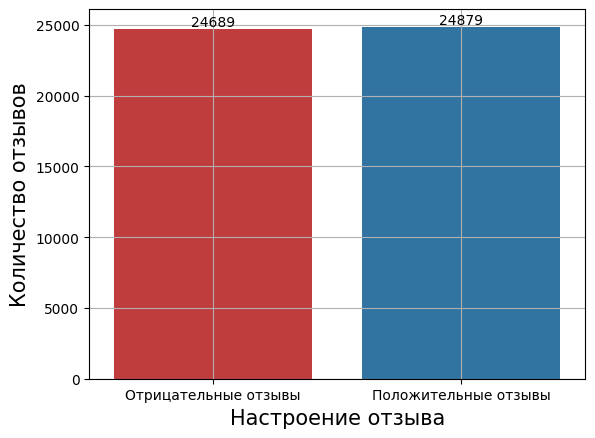

In [26]:
count = sns.countplot(binary_data['Mood'], palette = ['#D62728', '#1F77B4'])
lab = ['Отрицательные отзывы', 'Положительные отзывы']
count.bar_label(count.containers[0])
count.set_xticklabels(lab, fontsize = 10)
plt.grid(which = 'major')
plt.xlabel('Настроение отзыва', fontsize = 15)
plt.ylabel('Количество отзывов', fontsize = 15)
plt.show()

Находим длины слов в данных, чтобы получить их распределение для каждого из двух типов отзывов:

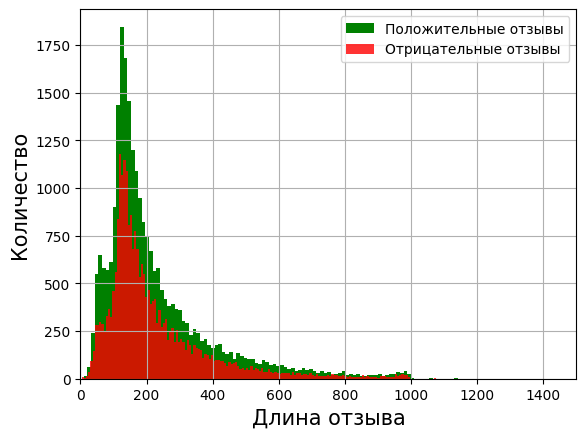

In [27]:
def word_len(text):
    return len(text.split(" "))
binary_data['Review length'] = binary_data['Review text'].apply(word_len)

n_bins = int(binary_data.shape[0]**(1/2))

plt.hist(binary_data[binary_data['Mood'] == 1]['Review length'], color = 'g', bins = n_bins)
plt.hist(binary_data[binary_data['Mood'] == 0]['Review length'], color = 'r', bins = n_bins, alpha=0.8)
plt.legend(['Положительные отзывы','Отрицательные отзывы'], fontsize = 10)
plt.xlabel('Длина отзыва', fontsize = 15)
plt.ylabel('Количество', fontsize = 15)
plt.xlim([0, 1500])
plt.grid(which = 'major')
plt.show()

In [28]:
print('Средняя длина отзыва составляет:', statistics.mean(binary_data['Review length']))
print('Медианная длина отзыва составляет:', statistics.median(binary_data['Review length']))

Средняя длина отзыва составляет: 227.23896465461587
Медианная длина отзыва составляет: 170.0


Создаем облака слов. Для негативных отзывов:

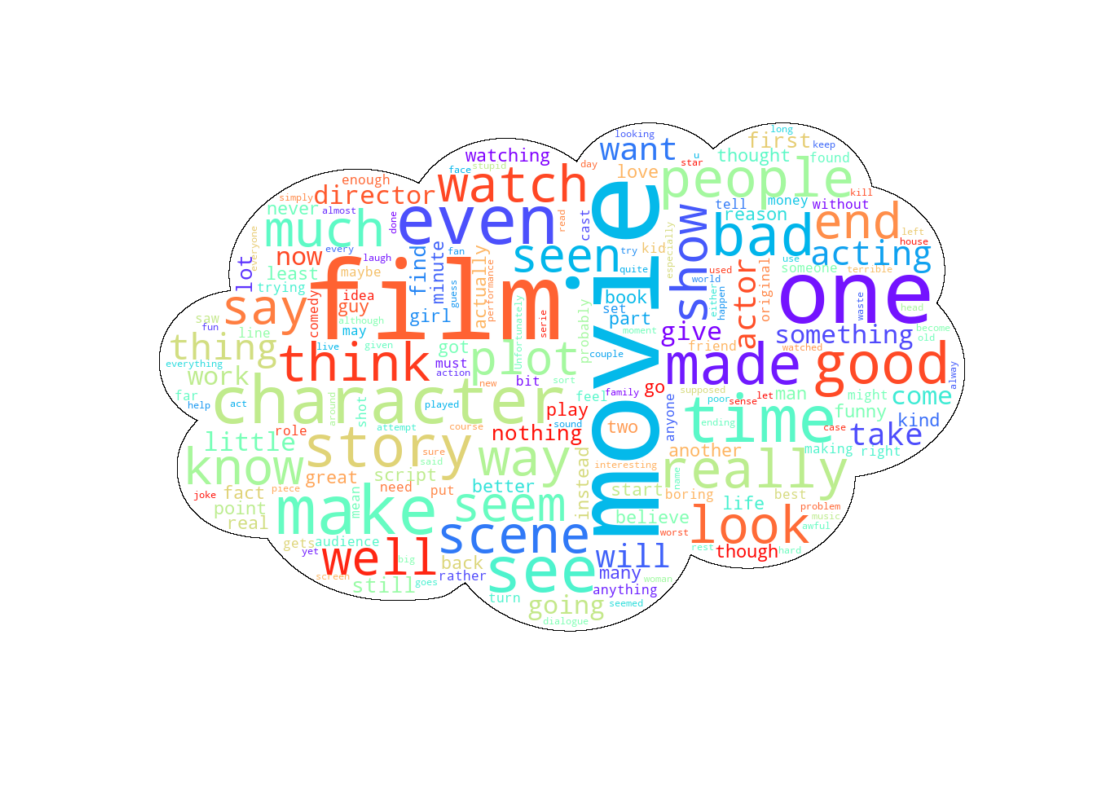

In [29]:
words = ' '.join(word for word in binary_data['Review text'][binary_data['Mood'] == 0].astype(str))
cloud = np.array(Image.open('cloud.png'))
wordCloud = WordCloud(width = 1600,
                      height = 800,
                      random_state = 20,
                      max_font_size = 150,
                      background_color = 'white',
                      colormap = 'rainbow',
                      mask = cloud,
                      contour_width = 1)
plt.figure(figsize = (15,10))
plt.imshow(wordCloud.generate(words),
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

Для позитивных отзывов:

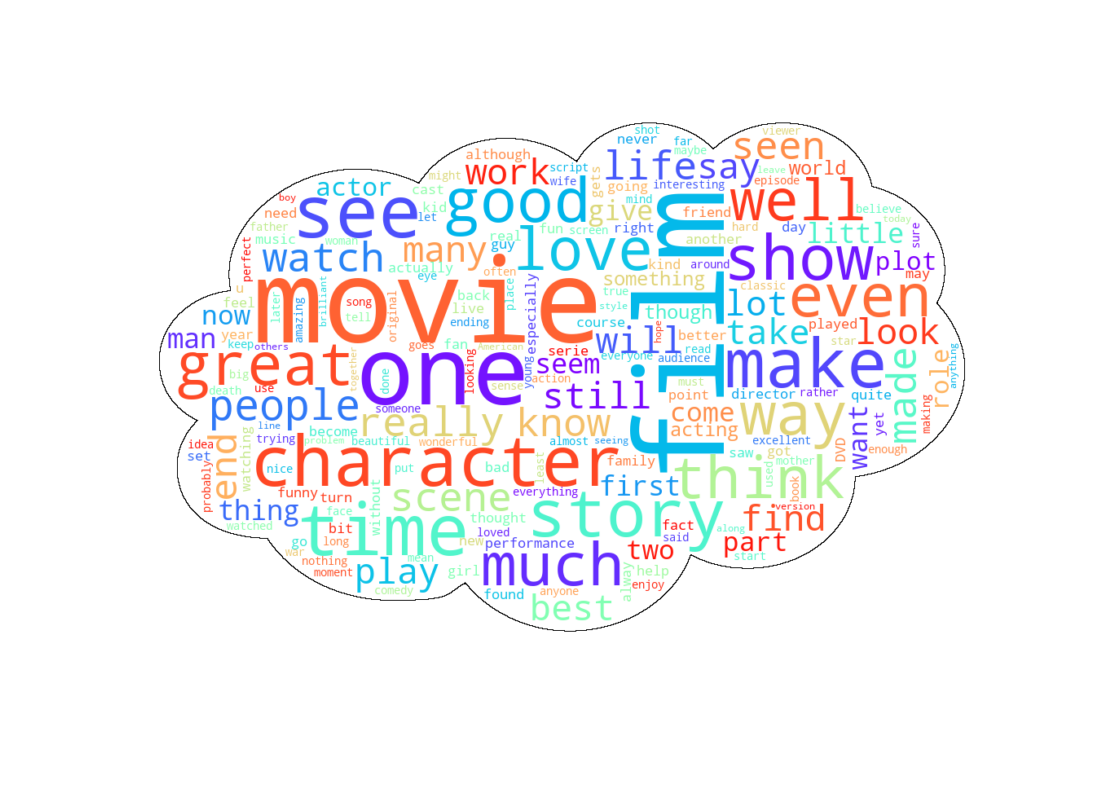

In [30]:
words = ' '.join(word for word in binary_data['Review text'][binary_data['Mood'] ==1].astype(str))
wordCloud=WordCloud(width = 1600,
                    height = 800,
                    random_state = 20,
                    max_font_size = 150,
                    background_color = 'white',
                    colormap = 'rainbow',
                    mask = cloud,
                    contour_width = 1)
plt.figure(figsize = (15,10))
plt.imshow(wordCloud.generate(words),
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Попытка обработки данных для мультиклассовой классификации

Напишем функцию `csv_grade`, которая извлекает из названия файлов оценки:

In [36]:
def csv_grade(path_name, path):
    data = []
    folder = os.listdir(path)
    for names in folder:
        grade = names[names.index('_') + 1 : names.index('.') + 1] 
        try:
            with open(path +'\\'+ names, 'r') as file:
                text = file.read().replace('\n', '').replace('''<br /><br />''', '')
                data.append([text, grade])
        except: pass
    df = pd.DataFrame(columns = ['Review text', 'Grade'], data = data)
    df.to_csv(path_name + '_grade' + '.csv', index = False)

Применяя указанную выше функицю, получаем файлы с оценками фильмов:

In [37]:
csv_grade('csv_data\\train_pos', 'aclImdb\\train\\pos')
csv_grade('csv_data\\train_neg', 'aclImdb\\train\\neg')
csv_grade('csv_data\\test_pos', 'aclImdb\\test\\pos')
csv_grade('csv_data\\test_neg', 'aclImdb\\test\\neg')

In [3]:
train_pos = pd.read_csv('csv_data\\train_pos_grade.csv')
train_neg = pd.read_csv('csv_data\\train_neg_grade.csv')
frames = [train_pos, train_neg]
train_data = pd.concat(frames, ignore_index = True)

test_pos = pd.read_csv('csv_data\\test_pos_grade.csv')
test_neg = pd.read_csv('csv_data\\test_neg_grade.csv')
frames = [test_pos, test_neg]
test_data = pd.concat(frames, ignore_index = True)

frames = [train_data, test_data]
data = pd.concat(frames, ignore_index = True)
data['Grade'] = data['Grade'].astype('int') # для удобства переводим оценки за фильм в целые числа

Рисуем круговую диаграмму (pie chart), отображающую количество отзывов с каждой оценкой:

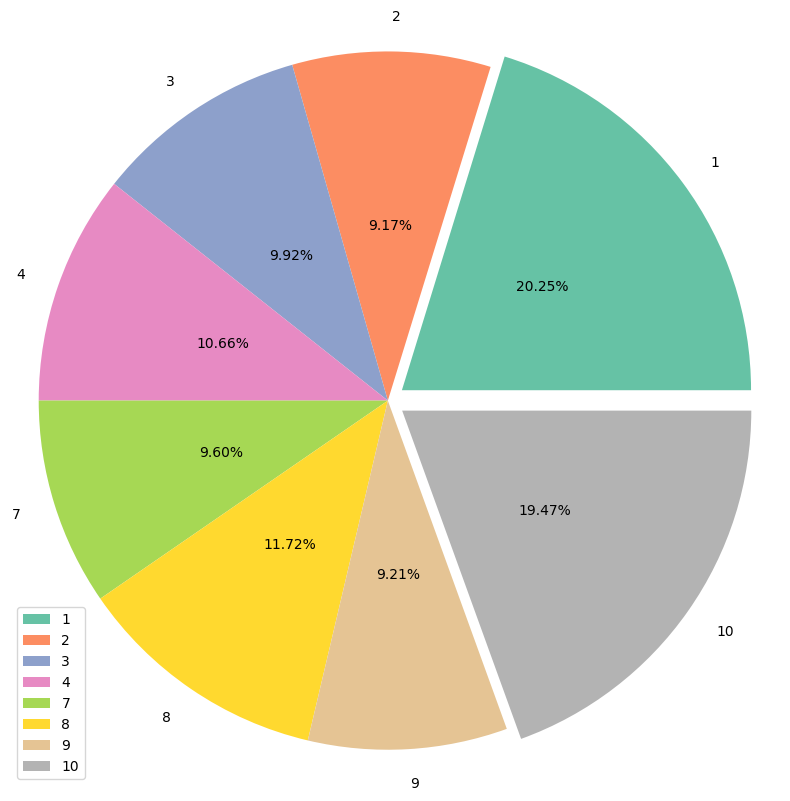

In [48]:
viz = data['Grade'].value_counts().sort_index()
pie = viz.plot(kind = 'pie',
                autopct = '%1.2f%%',
                colormap = 'Set2',
                figsize = (8,8),
                explode = [0.05, 0, 0, 0, 0, 0, 0, 0.05],
                pctdistance = 0.5,
                legend = True).yaxis.set_visible(False)
plt.legend(viz.index, loc = 'best')
plt.tight_layout()
plt.axis('equal')
plt.show()

Как видно из рисунока выше, классы несбалансированы, но что более критично, отсутствуют отзывы на фильмы с оценками 5 и 6. Следовательно, предсказание оценок фильмов будет ошибаться в случае с нейтральными отзывами. Хороший классификатор в данном случае построить достаточно проблематично.